## BEATLEX_adb Trial with test data: Summarizing and Forecasting Time Series with Patterns

### Abstract
Given time-series data such as electrocardiogram (ECG) readings, or motion capture data, how can we succintly summarize the data in a way that robustly identifies patterns that appear repeatedly? How can we then use such a summary to identify anomalies such as abnormal heartbeats, and also forecast future values of the time series? Our main idea is a vocabulary-based approach, which automatically learns a set of common patterns, or ‘beat patterns,’ which are used as building blocks to describe the time series in an intuitive and interpretable way. Our summarization algorithm, BEATLEX (BEAT LEXicons for Summarization) is: 1) fast and online, requiring linear time in the data size and bounded memory; 2) effective, outperforming competing algorithms in labelling accuracy by 5.3 times, and forecasting accuracy by 1.8 times; 3) principled and parameterfree, as it is based on the Minimum Description Length principle of summarizing the data by compressing it using as few bits as possible, and automatically tunes all its parameters; 4) general: it applies to any domain of time series data, and can make use of multidimensional (i.e. coevolving) time series.

You can configure the backend to use GPU or CPU only. \
Default is using backend cpu. 

In [1]:
import sys
sys.path.append("C:/Users/bailean/Documents/Bitbucket-Projects/spartan2")

import spartan as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using backend cpu


```loadTensor``` function automatically read data from file and ```toDTensor``` function extract time and value separately from the tensor.<br/>```Timeseries``` class is designed to construct time tensor.

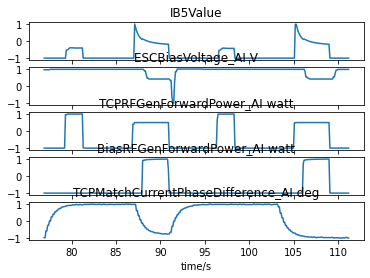

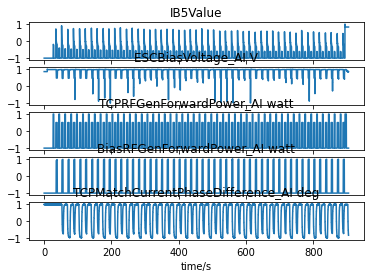

np.shape(time_series.val_tensor)=(5, 9043) end=9043


In [3]:
fullset = 'inputData/LRCX-1/05-01-23_Dataset3_SJSUcase.csv'
subset = 'inputData/LRCX-1/05-01-23_DataSUBset3_SJSUcase.csv'
LRCXfilepath = subset
pulse_AO = 60
kwargs = {
        'header': 0,
        'usecols': [0, 8, 13, 67, 61, 36]
                    #36, 38, 120, 77 ] # of interest for full dataset3
                    #60, 13,  67, 8 ] # corresponding for SUBset of dataset3  
                    #OES in subset [0,8,18,20,22,23,25,26,28,30,31,32,33]
        }
df = pd.read_csv(LRCXfilepath)
if not kwargs['usecols'] is None: 
        labels = df.columns[sorted(kwargs['usecols'][1:])]
        time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*(len(labels)+1), sep=',', **kwargs).toDTensor(hastticks=True)
else:
        kwargs.pop('usecols') 
        labels = df.columns[1:]
        time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*(len(labels)+1), sep=',', **{'header': 0}).toDTensor(hastticks=True)

# print(f"{labels=}, code doesn't want time label which must be firt usecols index")
width = 342
for beat in [0]:
        if 1112 + width*beat < 8756:
                time_series = st.Timeseries(value, time, labels = labels).cut(start=768 + width*beat, end=1112 + width*beat, inplace=False).normalize(inplace=False)
                st.plot_timeseries(time_series)

delay_start = 767
cut_end = 8756
start = 0
end = len(time)
time_series = st.Timeseries(value, time, labels = labels).cut(start=start, end=end, inplace=False).normalize(inplace=False)
st.plot_timeseries(time_series)
# print(f"time series {time_series}, type {type(time_series)}")
print(f"{np.shape(time_series.val_tensor)=} {end=}")

### Run Beatlex from specific task

In [4]:
if False : 
    ss_task = st.Summarization.create(time_series, st.SumPolicy.BeatLex, 'my_beatlex_model')

In [5]:
if False: 
    result = ss_task.run()

### Run Beatlex as a single model

In [6]:
print(f"{time_series.freq=}\n{time_series.labels=}")

time_series.freq=10.001139132290861
time_series.labels=['IB5Value', 'ESCBiasVoltage_AI V', 'TCPRFGenForwardPower_AI watt', 'BiasRFGenForwardPower_AI watt', 'TCPMatchCurrentPhaseDifference_AI deg']


init at 20

========segment 2 at 21 120
cluster cost [1.95160463e-05]
new cluster cost for 5: 1.2090673550551365
size chosen: 22
cluster 0

========segment 3 at 43 142
cluster cost [3.19811794e-05]
new cluster cost for 5: 1.2090673550551365
size chosen: 31
cluster 0

========segment 4 at 74 173
cluster cost [0.00013046]
new cluster cost for 5: 1.2090673550551365
size chosen: 20
cluster 0

========segment 5 at 94 193
cluster cost [0.00276965]
new cluster cost for 5: 1.2090673550551365
size chosen: 67
cluster 0

========segment 6 at 161 260
cluster cost [0.00156676]
new cluster cost for 5: 1.2090673550551365
size chosen: 90
cluster 0

========segment 7 at 251 350
cluster cost [0.19759114]
new cluster cost for 5: 1.2090673550551365
size chosen: 91
cluster 0

========segment 8 at 342 441
cluster cost [0.53394088]
new cluster cost for 5: 1.2090673550551365
size chosen: 91
new_cluster
best_place: [49, 0, 20]
best_S1: 49
new cluster starts 342 ends 391

========segment 9 at 392 491
cluster co

C:\Users/bailean/Documents/Bitbucket-Projects/spartan2\spartan\model\beatlex\Beatlex.py:73: RuntimeWarning: All-NaN slice encountered
  best_cost = np.nanmin(ave_costs)


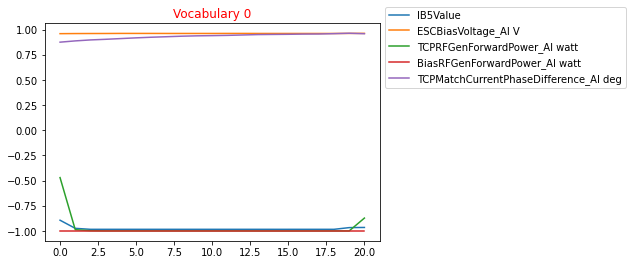

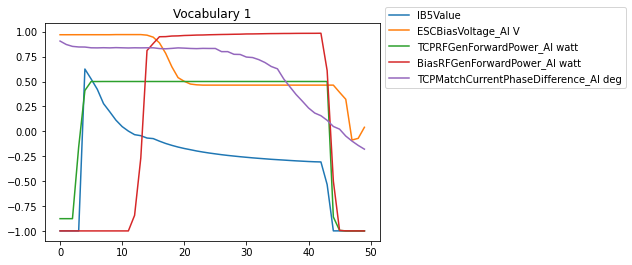

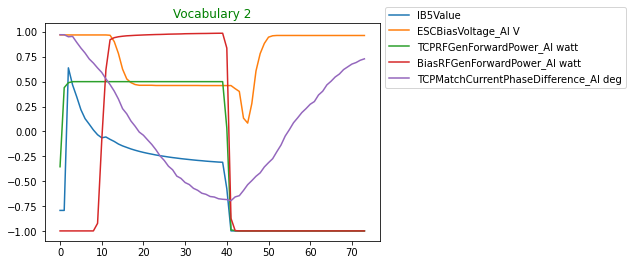

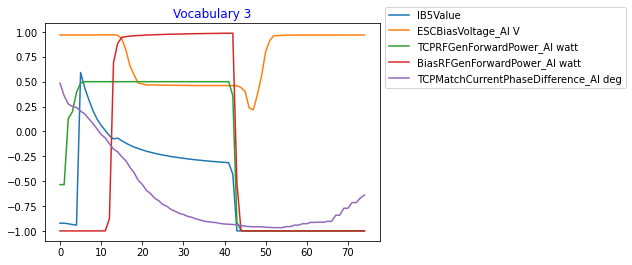

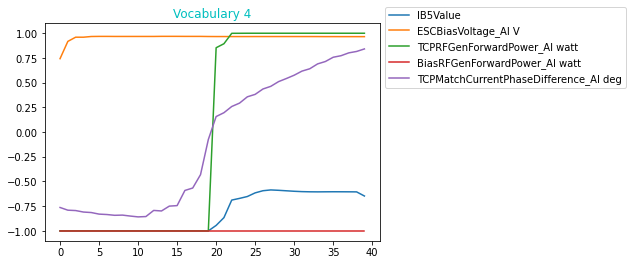

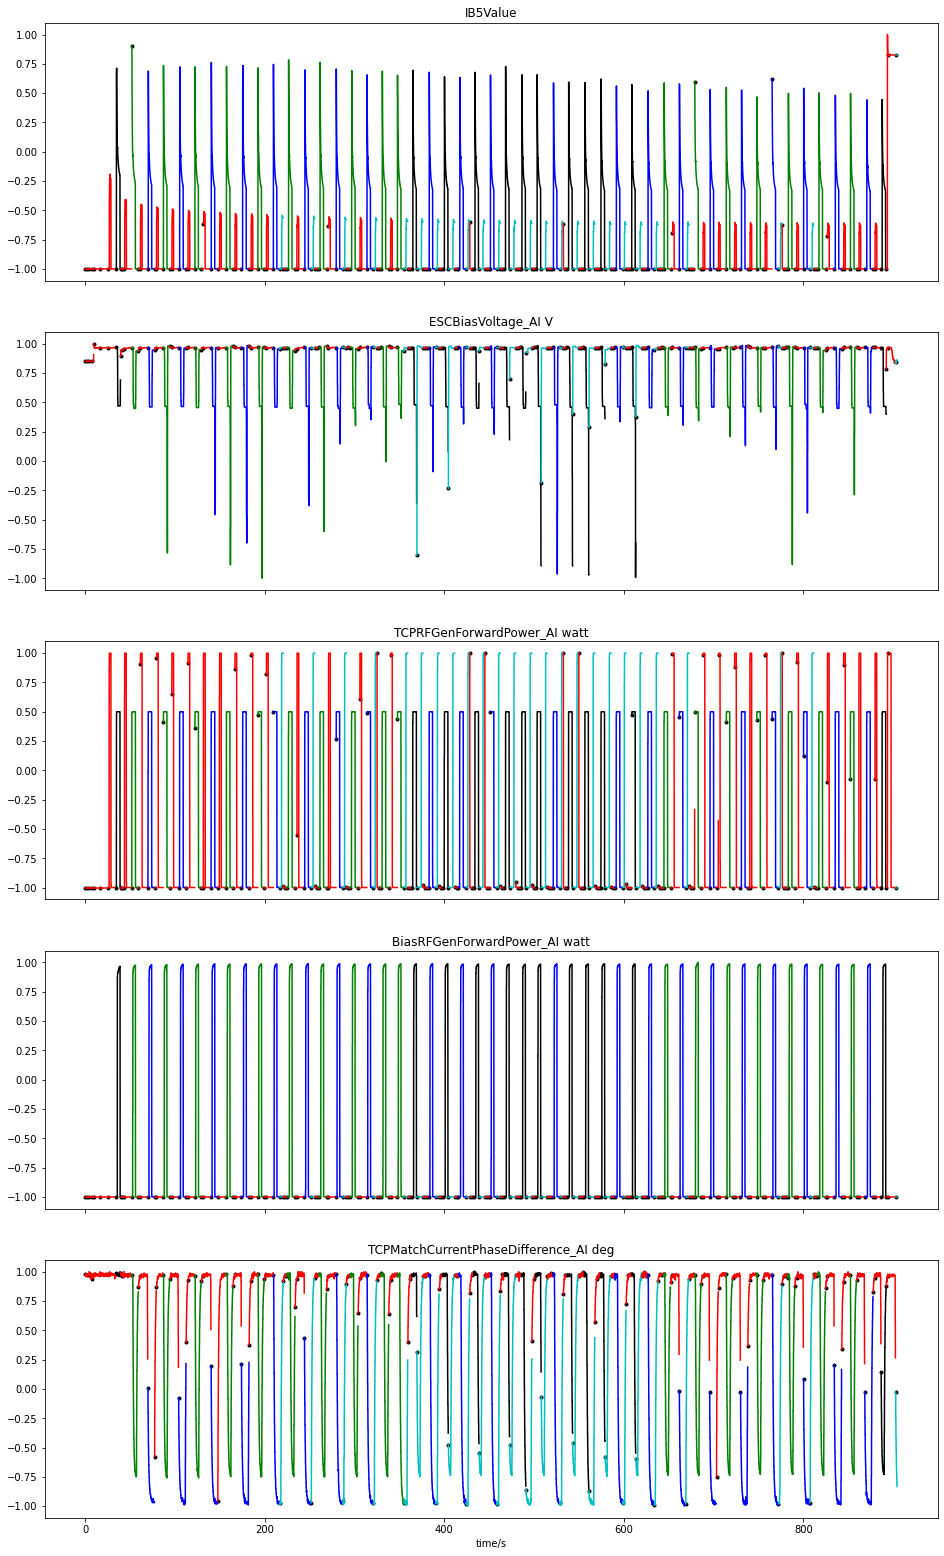

In [57]:
para_dict = {
    'signal_freq': time_series.freq,
    'Smin': 20,
    'Smax': 100,
    'max_dist': 70, # Sakoe Chiba bandwidth for modified DTW; between (Smax-Smin)/2 and Smax-Smin
    'prediction_length': 0,
    'model_momentum': 0,
    'max_vocab': 5,
    'termination_threshold': 0,
    'new_cluster_threshold': 0.3
}
beatlex = st.BeatLex(time_series, **para_dict)
result = beatlex.run()
st.plot(st.BeatLex, time_series, result)

In [58]:
print(f"{result.keys()=}")
print(f"{list(zip(result['starts'], result['ends']))=}")
print(f"result['models'] contain the vocab words {len(result['models'])=}, eg, {np.shape(result['models'][0])=}")
print(f"{result['idx']=}")

result.keys()=dict_keys(['signal_freq', 'tot_err', 'starts', 'ends', 'idx', 'best_prefix_length', 'models'])
list(zip(result['starts'], result['ends']))=[(0, 20), (21, 42), (43, 73), (74, 93), (94, 160), (161, 250), (251, 341), (342, 391), (392, 412), (413, 433), (434, 516), (517, 590), (591, 611), (612, 695), (696, 770), (771, 791), (792, 867), (868, 941), (942, 962), (963, 1037), (1038, 1121), (1122, 1142), (1143, 1218), (1219, 1292), (1293, 1313), (1314, 1399), (1400, 1473), (1474, 1564), (1565, 1643), (1644, 1664), (1665, 1737), (1738, 1823), (1824, 1844), (1845, 1921), (1922, 1994), (1995, 2015), (2016, 2093), (2094, 2165), (2166, 2205), (2206, 2226), (2227, 2247), (2248, 2335), (2336, 2355), (2356, 2439), (2440, 2515), (2516, 2556), (2557, 2577), (2578, 2598), (2599, 2686), (2687, 2707), (2708, 2792), (2793, 2865), (2866, 2907), (2908, 2928), (2929, 2949), (2950, 3037), (3038, 3057), (3058, 3136), (3137, 3208), (3209, 3248), (3249, 3269), (3270, 3290), (3291, 3379), (3380, 3399),

In [59]:
result['map_err'] = []
result['map_offset'] = []
for word, word_id in enumerate(result['idx']):
    t_start = result['starts'][word]
    t_end = result['ends'][word]+1
    time_span = np.s_[t_start: t_end]
    map_err = []
    word_offset = []
    word_len = np.shape(result['models'][word_id])[1]
    for sig, letter in enumerate(result['models'][word_id]):
        #calculate a naive flat mapping error rather than the modified DTW err
        raw_data = np.asarray(time_series.val_tensor[sig, time_span])
        # print(f"{word_len=} {np.shape(raw_data)=}")
        raw_data_len = len(raw_data)
        if word_len <= raw_data_len: 
            sliding_word = 1
            small_snip = letter
            short_len = word_len
            large_snip = raw_data
        else:
            sliding_word = -1
            small_snip = raw_data
            short_len = raw_data_len
            large_snip = letter 
        number_of_flat_maps = (raw_data_len - word_len) * sliding_word + 1
        min_err = 999
        min_offset = 0

        for t_offset in range(number_of_flat_maps):
            #print(f"{t_start + t_offset}")
            if word_id == 99 : 
                print(f"{list(zip(letter,raw_data[t_offset:t_offset + word_len]))=}")
                print(f"{letter - raw_data[t_offset:t_offset + word_len]=}")
            test_err = np.std(small_snip - large_snip[t_offset:t_offset + short_len])
            if (test_err <= min_err) or (t_offset == 0) :
                min_err = test_err
                min_offset = t_offset * sliding_word
        map_err.append(min_err)
        word_offset.append(min_offset)
    result['map_err'].append(map_err)
    result['map_offset'].append(word_offset)
print(f"{np.shape(np.asarray(result['map_err']))=}")
# print(f"{np.asarray(result['map_err'])=}")

np.shape(np.asarray(result['map_err']))=(193, 5)


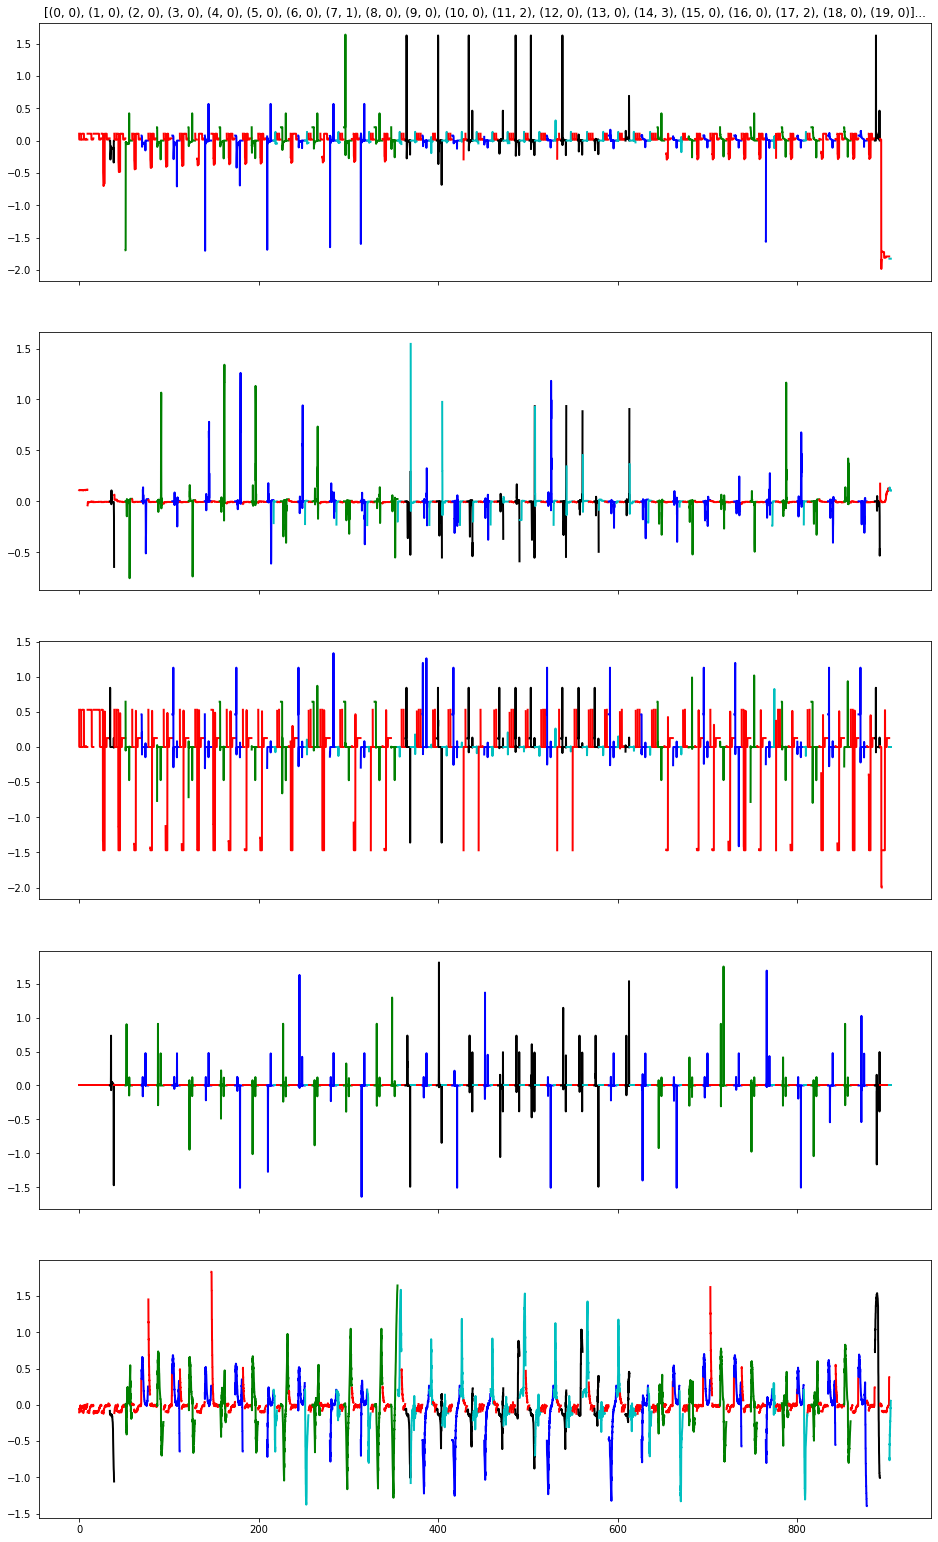

In [60]:
## Calculate the mean std error of the reconstruction for each signal
num_words = len(result['idx'])
plot_words = [0,3,5] #[-2, -1]
plot_words = [i for i in range(len(result['idx'])) if result['idx'][i] in [3]][0:3]
# plot_words = np.arange(min(plot_words), max(plot_words)+1)
plot_words = np.arange(0, num_words)
plot_delta = True
num_letters = len(result['models'][0])
numrows = num_letters 
color = ['r', 'k', 'g', 'b', 'c', 'm'] * (int(numrows / 6) + 1)
numcols = 1
figxsize = 16
figysize = 5.5
fig, allax = plt.subplots(nrows=numrows, ncols=numcols, 
                            figsize=(figxsize * numcols, figysize * numrows), 
                            sharex=True)
for word in plot_words:
    t_start = result['starts'][word]
    t_end = result['ends'][word]
    time_span = np.s_[t_start: t_end]
    word_id = result['idx'][word]
    word_len = len(result['models'][word_id][1])
    for sig, letter in enumerate(result['models'][word_id]):
        if plot_delta :
            raw_data = np.asarray(time_series.val_tensor[sig, time_span])
            raw_time = np.asarray(time_series.time_tensor[time_span])
            letter_time = np.divide(np.arange(word_len) + result['map_offset'][word][sig], time_series.freq) + time_series.time_tensor[t_start]
            letter_interp = np.interp(raw_time, letter_time, letter, left=letter[0], right=letter[-1])
            # print(f"{word_len=} {np.shape(raw_data)=}")
            
            delta = letter_interp - raw_data
            trim_ends = 0
            allax[sig].plot(raw_time[trim_ends:-(trim_ends+1)], delta[trim_ends:-(trim_ends+1)] , '-', linewidth = 2, alpha = 1,
                            color=color[word_id % num_letters], label = str(np.round(result['map_err'][word][sig],3)) +' err vocab ' + str(word_id) + ' : letter' + str(sig))
        else:    
            allax[sig].plot(np.divide(np.arange(word_len) + result['map_offset'][word][sig], time_series.freq) + time_series.time_tensor[t_start], letter, '--', linewidth = 4, alpha = 0.5,
                            color=color[word_id % num_letters], label = str(np.round(result['map_err'][word][sig],3)) +' err vocab ' + str(word_id) + ' : letter' + str(sig))
            allax[sig].plot(time_series.time_tensor[time_span], time_series.val_tensor[sig, time_span], color = 'k', linewidth=2, label = 'raw ' + str(time_series.labels[sig]) )
        if len(plot_words) < 7 :
            allax[sig].legend(loc ='upper left', bbox_to_anchor=(1, 1, .1, .1))
if len(plot_words) > 20 : 
    allax[0].set_title(str(list(zip(plot_words, np.array(result['idx'])[0:20]))) + '...')
else:
    allax[0].set_title(str(list(zip(plot_words, np.array(result['idx'])))))

plt.show()
    

Vocabularies | Segmentation
:-------------------------:|:-------------------------:
<img src="images/beatlexSum1.png" width="300"/>  |   <img src="images/beatlexSum2.png" width="300"/>
<b>Vocabularies learned by BeatLex. |  <b>Segmentation made by BeatLex.

### Experiment Results
------
Beatlex(ECG)      |  Beatlex(Motion)
:-------------------------:|:-------------------------:
<img src="images/beatlexExp1.png" width="300"/>  |   <img src="images/beatlexExp2.png" width="300"/>
<b>Beatlex segments and labels data. |  <b>Beatlex learns vocabulary.

### Cite:
------
1. Hooi, Bryan, et al. "B eat L ex: Summarizing and Forecasting Time Series with Patterns." Joint European Conference on Machine Learning and Knowledge Discovery in Databases. Springer, Cham, 2017.

    <details>
    <summary><span style="color:blue">click for BibTex...</span></summary>

    ```bibtex
    @inproceedings{hooi2017b,
      title={B eat L ex: Summarizing and Forecasting Time Series with Patterns},
      author={Hooi, Bryan and Liu, Shenghua and Smailagic, Asim and Faloutsos, Christos},
      booktitle={Joint European Conference on Machine Learning and Knowledge Discovery in Databases},
      pages={3--19},
      year={2017},
      organization={Springer}
    }
    ```
    </details>